In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cpu')

def moving_average(data, window_size):
    weights = np.ones(window_size) / window_size
    return np.convolve(data, weights, mode='valid')

def euler_step(model, t, dt, x_last, m=1):
    dx = model(t, x_last)
    x_next = x_last + dx * dt
    return x_next

def train(model, t_data, x_data, lr=0.01, milestones=[], gamma=0.1):
    from datetime import datetime
    import random
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma, last_epoch=-1)
    loss_fn = nn.MSELoss()
    x_true_grads = torch.zeros_like(x_data)
    for i in range(1, x_data.size(1)):
        x_true_grads[:, i, :] = (x_data[:, i, :] - x_data[:, i - 1, :]) / (t_data[:, i] - t_data[:, i - 1])
    loss_curve = []
    real_loss_curve = []
    n = 0
    epoch = 0
    while n<60:
        model.train()
        optimizer.zero_grad()
        t = t_data[n, :]
        x = x_data[:, :, n]
        x_preds = torch.zeros_like(x)
        x_preds[:, 0] = x[:, 0].clone().detach().requires_grad_(True)
        x_grads = torch.zeros_like(x)
        for i in range(1, len(t)):
            dt = t[i] - t[i - 1]
            x_pred = x_preds[:, i - 1].clone()
            dx = model(t[i], x_pred).requires_grad_(True)
            x_pred = euler_step(model, t[i], dt, x_pred)
            x_preds[:, i] = x_pred
            x_grads[:, i] = dx
        loss = loss_fn(x_grads, x_true_grads[:, :, n])
        loss.backward(retain_graph=True)
        optimizer.step()
        scheduler.step()
        loss_curve.append(loss.cpu().detach().numpy())
        real_loss = loss_fn(x_preds, x)
        real_loss_curve.append(real_loss.cpu().detach().numpy())
        if loss.item()<0.3:
            torch.save(model, 'wide_single_layer_model.pt')
        if loss.item()<0.05:
            n += 1
        if (epoch + 1) % 10 == 0:
            current_time = datetime.now()
            current_time = current_time.strftime("%H:%M:%S")
            model_device = next(model.parameters()).device
            print('sample', n,'epoch', epoch + 1, current_time, model_device, 'real loss:', real_loss.detach().numpy(),
                  'derivate loss:', loss.detach().numpy())
        epoch += 1
    return model, x_preds, loss_curve, real_loss_curve

In [14]:
data = np.load('data_set.npz')
t_data = data['t_data']
x_data = data['x_data']

window_size = 10  # Adjust window size as needed
#x_data_ma = np.array([moving_average(row, window_size) for row in x_data])

x_tensor = torch.tensor(x_data, dtype=torch.float32).requires_grad_(True).to(device)
t_tensor = torch.tensor(t_data, dtype=torch.float32).requires_grad_(True).to(device)

class ODEModel(nn.Module):
    def __init__(self):
        super(ODEModel, self).__init__()
        self.fc1 = nn.Linear(3, 1000)
        self.fc2 = nn.Linear(1000, 2)
        self.elu = nn.ELU()
        self.relu = nn.ReLU()
    def forward(self, t, x):
        t = torch.unsqueeze(t, dim=0)
        x = torch.cat((t, x), dim=0)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
model = ODEModel().to(device)
loss_fn = nn.MSELoss()
model, x_preds, loss_curve, real_loss_curve = train(model, t_tensor, x_tensor, lr=0.005, milestones=[], gamma=0.1)
torch.save(model, 'wide_single_layer_model.pt')

sample 0 epoch 10 01:12:39 cpu real loss: 4.2737293 derivate loss: 1.8042707
sample 0 epoch 20 01:12:53 cpu real loss: 3.4797623 derivate loss: 1.7312636
sample 0 epoch 30 01:13:06 cpu real loss: 3.4144137 derivate loss: 1.6315161
sample 0 epoch 40 01:13:20 cpu real loss: 6.3819656 derivate loss: 2.0172412
sample 0 epoch 50 01:13:33 cpu real loss: 4.09506 derivate loss: 1.9417807
sample 0 epoch 60 01:13:46 cpu real loss: 2.8129537 derivate loss: 1.7751278
sample 0 epoch 70 01:13:59 cpu real loss: 2.4583814 derivate loss: 1.6803899
sample 0 epoch 80 01:14:13 cpu real loss: 2.1208613 derivate loss: 1.603303
sample 0 epoch 90 01:14:26 cpu real loss: 2.1395729 derivate loss: 1.5403818
sample 0 epoch 100 01:14:40 cpu real loss: 2.2013066 derivate loss: 1.4788157
sample 0 epoch 110 01:14:54 cpu real loss: 2.1863103 derivate loss: 1.4163327
sample 0 epoch 120 01:15:07 cpu real loss: 2.1482651 derivate loss: 1.3606474
sample 0 epoch 130 01:15:21 cpu real loss: 2.0998845 derivate loss: 1.310474

KeyboardInterrupt: 

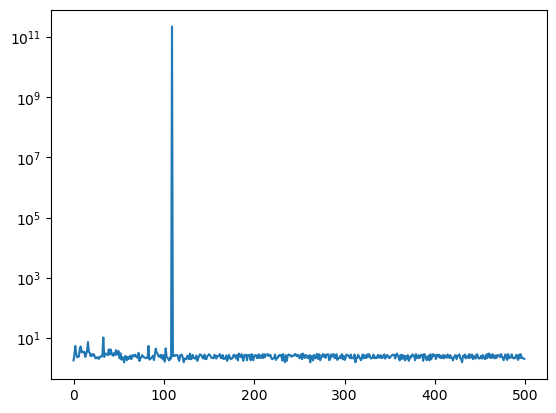

In [7]:
plt.plot(real_loss_curve)
plt.yscale('log')

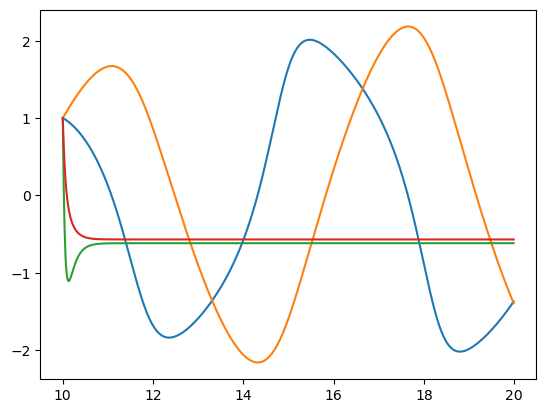

In [8]:
data = np.load('data_test.npz')
t_data_test = data['t_data']
x_data_test = data['x_data']
x_data_test = torch.tensor(x_data_test, dtype=torch.float32).to(device)
t_data_test = torch.tensor(t_data_test, dtype=torch.float32).unsqueeze(1).to(device)
x0 = x_data_test[:,0]
x_preds_test = nfode.predict(model, t_data_test, x0)
t_data_test = t_data_test.detach().numpy()
x_data_test = x_data_test.detach().numpy()
plt.plot(t_data_test, x_data_test.T)
plt.plot(t_data_test, x_preds_test)